# Preprocessing

### Importing libraries and datasets

In [607]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import functions as cf 

from sklearn.preprocessing import MinMaxScaler, StandardScaler, PowerTransformer, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as mse, mean_absolute_error as mae, r2_score
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import cross_val_score
import statsmodels.api as sm


In [608]:
combined_file_path = '../data/cleaned/winequality_combined_cleaned.csv' 
red_file_path = '../data/cleaned/winequality_red_cleaned.csv'
white_file_path = '../data/cleaned/winequality_white_cleaned.csv'
combined_df = pd.read_csv(combined_file_path)
red_df = pd.read_csv(red_file_path, index_col=0)
white_df = pd.read_csv(white_file_path, index_col=0)
white_df

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.00100,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.99400,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.99510,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
4,6.2,0.32,0.16,7.0,0.045,30.0,136.0,0.99490,3.18,0.47,9.6,6
...,...,...,...,...,...,...,...,...,...,...,...,...
3956,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,6
3957,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,5
3958,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,6
3959,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,7


In [609]:
def linear_regression(X_train, X_test, y_train, y_test):
    # Linear regression
    lm = LinearRegression()
    model = lm.fit(X_train, y_train)
    print(f'model coefficients:\n {model.coef_}\n')
    print(f'model intercept:\n {model.intercept_}\n')
    
    # Applying model to X test
    y_pred = model.predict(X_test)
    
    # Ensure y_test is in the correct format (pandas Series or 1D numpy array)
    if isinstance(y_test, pd.Series):
        y_test_reset = y_test.reset_index(drop=True)
    else:
        y_test_reset = y_test  # Assuming y_test is already a numpy array
    
    # Creating combined table with y_test and y_pred
    # Check if y_test_reset is a pandas Series and convert y_pred to a similar type
    if isinstance(y_test_reset, pd.Series):
        y_pred_series = pd.Series(y_pred, index=y_test_reset.index, name='y_pred')
        residuals_df = pd.concat([y_test_reset, y_pred_series], axis=1)
    else:
        # If inputs are numpy arrays, stack them horizontally
        residuals_df = np.column_stack((y_test_reset, y_pred))
        # Convert to DataFrame for easier manipulation later on
        residuals_df = pd.DataFrame(residuals_df, columns=["y_test", "y_pred"])
    
    # Calculating residuals
    residuals_df["residual"] = residuals_df["y_test"] - residuals_df["y_pred"]
    print(f'Residuals:\n {residuals_df}\n')

    # Root mean squared error
    rmse = mse(y_test_reset, residuals_df["y_pred"], squared=False)
    print(f'Root mean squared error: {rmse} \n')

    # R^2
    r2 = r2_score(y_test_reset, residuals_df["y_pred"])
    print(f'R2: {r2} \n')

    # Calculating adjusted R^2
    n = X_train.shape[0]  # Number of observations in the training set
    p = X_train.shape[1]  # Number of features used for training
    adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
    print(f'Adjusted R2: {adjusted_r2} \n')

    return model.coef_


import pandas as pd
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import r2_score



def evaluate_model_performance(y_test, y_pred, X_train):
    """
    Evaluates the performance of a regression model by calculating and printing
    the ME, MAE, MSE, RMSE, R^2, and adjusted R^2.

    Parameters:
    - y_test: pandas Series or DataFrame, actual target values.
    - y_pred: array-like or pandas Series, predicted target values.
    - X_train: pandas DataFrame, feature set used for training the model.

    Returns:
    - Prints the ME, MAE, MSE, RMSE, R^2, and adjusted R^2 of the model.
    """
    # Ensure y_pred is a DataFrame with appropriate column name
    if not isinstance(y_pred, pd.DataFrame):
        y_pred = pd.DataFrame(y_pred, columns=["y_pred"])
    else:
        y_pred = y_pred.rename(columns={y_pred.columns[0]: "y_pred"})

    # Reset index and rename y_test for consistency
    if isinstance(y_test, pd.Series):
        y_test = y_test.reset_index(drop=True).rename("y_test")
    elif isinstance(y_test, pd.DataFrame):
        y_test = y_test.reset_index(drop=True)
        y_test.columns = ["y_test"]

    # Concatenate actual and predicted values and calculate residuals
    residuals_df = pd.concat([y_test, y_pred], axis=1)
    residuals_df["residual"] = residuals_df["y_test"] - residuals_df["y_pred"]

    # Calculate Mean Error (ME)
    me = residuals_df["residual"].mean()
    print(f'Mean Error (ME): {me:.4f}')

    # Calculate Mean Absolute Error (MAE)
    mae_value = mae(residuals_df["y_test"], residuals_df["y_pred"])
    print(f'Mean Absolute Error (MAE): {mae_value:.4f}')

    # Calculate Mean Squared Error (MSE)
    mse_value = mse(residuals_df["y_test"], residuals_df["y_pred"])
    print(f'Mean Squared Error (MSE): {mse_value:.4f}')

    # Calculate Root Mean Squared Error (RMSE)
    rmse = mse(residuals_df["y_test"], residuals_df["y_pred"], squared=False)
    print(f'Root Mean Squared Error (RMSE): {rmse:.4f}')

    # Calculate R^2
    r2 = r2_score(residuals_df["y_test"], residuals_df["y_pred"])
    print(f'R²: {r2:.4f}')

    # Calculate Adjusted R^2
    n = X_train.shape[0]  # Number of observations
    p = X_train.shape[1]  # Number of features
    adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
    print(f'Adjusted R²: {adjusted_r2:.4f}')



## Correlations

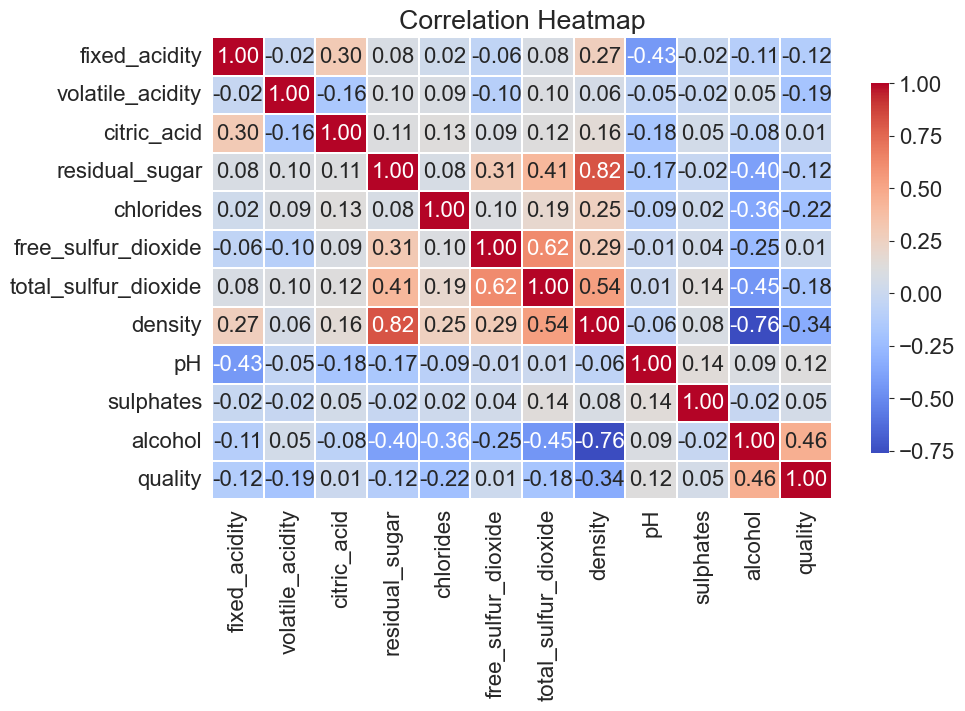

In [610]:
#White_wine
corr_matrix_white = white_df.corr()
plt.figure(figsize=(10, 6)) 
sns.heatmap(corr_matrix_white, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.05, cbar_kws={'shrink': .8})
plt.title('Correlation Heatmap')  
plt.show()


## IQR Method to handle Outliers

In [611]:
def outlier_thresholds(dataframe, variable):
    quartile1 = dataframe[variable].quantile(0.25)
    quartile3 = dataframe[variable].quantile(0.75)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = round(low_limit,5)
    dataframe.loc[(dataframe[variable] > up_limit), variable] = round(up_limit,5)
    


In [612]:
white_df.columns

Index(['fixed_acidity', 'volatile_acidity', 'citric_acid', 'residual_sugar',
       'chlorides', 'free_sulfur_dioxide', 'total_sulfur_dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality'],
      dtype='object')

In [613]:
print(white_df.head())

   fixed_acidity  volatile_acidity  citric_acid  residual_sugar  chlorides  \
0            7.0              0.27         0.36            20.7      0.045   
1            6.3              0.30         0.34             1.6      0.049   
2            8.1              0.28         0.40             6.9      0.050   
3            7.2              0.23         0.32             8.5      0.058   
4            6.2              0.32         0.16             7.0      0.045   

   free_sulfur_dioxide  total_sulfur_dioxide  density    pH  sulphates  \
0                 45.0                 170.0   1.0010  3.00       0.45   
1                 14.0                 132.0   0.9940  3.30       0.49   
2                 30.0                  97.0   0.9951  3.26       0.44   
3                 47.0                 186.0   0.9956  3.19       0.40   
4                 30.0                 136.0   0.9949  3.18       0.47   

   alcohol  quality  
0      8.8        6  
1      9.5        6  
2     10.1        6 

### Distributions

### Splitting data into X and y

In [614]:
X = white_df.drop(['quality'], axis=1)
#X = pd.DataFrame(red_df[['citric_acid', 'total_sulfur_dioxide', 'density', 'pH', 'residual_sugar', 'chlorides', 'sulphates', 'alcohol']])
y = pd.DataFrame(white_df["quality"])

X_train, X_test, y_train, y_test = train_test_split(X,y, random_state = 42)

## Linear Regression Model 

In [615]:
# Linear regression
lm = LinearRegression()
model = lm.fit(X_train, y_train)
print(f'model coefficients:\n {model.coef_}\n')
print(f'model intercept:\n {model.intercept_}\n')

# Applying model to X test
y_pred = model.predict(X_test)
#y_pred = pd.DataFrame(scaler_s_y.inverse_transform(y_pred)) # inversing y
y_pred = pd.DataFrame(y_pred)

y_pred = y_pred.rename(columns = {0:"y_pred"})

y_test = y_test.reset_index(drop=True)
y_test = y_test.rename(columns = {"quality":"y_test"})

# Model to predict a specific instance 

instance_to_predict = X.loc[[3131]]  # Assuming 3131 is the index of the instance
quality_prediction = model.predict(instance_to_predict)

print("Predicted quality:", quality_prediction)

# Calculating residuals 

residuals_df = pd.concat([y_test,y_pred], axis = 1)
residuals_df["residual"] = residuals_df["y_test"] - residuals_df["y_pred"]


# Root mean squared error
rmse = mse(y_test, residuals_df["y_pred"], squared=False)
print(f'Root mean squared error: {rmse} \n')

# R^2
r2 = r2_score(y_test, residuals_df["y_pred"])
print(f'R2: {r2} \n')

# Calculating adjusted R^2
n = X_train.shape[0]  # Number of observations in the training set
p = X_train.shape[1]  # Number of features used for training
adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
print(f'Adjusted R2: {adjusted_r2} \n')

residuals_df

model coefficients:
 [[ 2.73545382e-02 -1.73075979e+00  2.83481477e-01  5.68876068e-02
  -5.35112531e-01  6.13962626e-03 -7.21149251e-04 -1.05948559e+02
   6.58388061e-01  6.17340839e-01  2.53924821e-01]]

model intercept:
 [105.82232538]

Predicted quality: [[6.00923597]]
Root mean squared error: 0.7602594114083735 

R2: 0.2679879353976543 

Adjusted R2: 0.2652657809992006 



,y_test,y_pred,residual
0,4,6.387488,-2.387488
1,6,5.547425,0.452575
2,5,5.364127,-0.364127
3,6,5.605360,0.394640
4,7,6.281155,0.718845
...,...,...,...
986,5,5.491947,-0.491947
987,5,5.457485,-0.457485
988,5,5.204799,-0.204799
989,7,6.135139,0.864861


In [571]:
residuals_df["residual"].mean()

0.016412908952995933

In [572]:
mse = mse(y_test,residuals_df["y_pred"])
mse


0.5779943726350065

In [573]:
mae = mae(y_test,residuals_df["y_pred"])
mae

0.5880084263372415

In [574]:
import statsmodels.api as sm
X_train = sm.add_constant(X_train)
model = sm.OLS(y_train,X_train).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                quality   R-squared:                       0.308
Model:                            OLS   Adj. R-squared:                  0.306
Method:                 Least Squares   F-statistic:                     119.9
Date:                Fri, 09 Feb 2024   Prob (F-statistic):          2.67e-227
Time:                        07:07:26   Log-Likelihood:                -3324.7
No. Observations:                2970   AIC:                             6673.
Df Residuals:                    2958   BIC:                             6745.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                  105.8223     21.894      4.833      0.000      62.893     148.751
fixed_acidity            0.0274      0.026      1.069      0.285      -0.023       0.078
volatile_acidity        -1.7308      0.145    -11.956      0.000      -2.015      -1.447
citric_acid              0.2835      0.122      2.330      0.020       0.045       0.522
residual_sugar           0.0569      0.009      6.265      0.000       0.039       0.075
chlorides               -0.5351      0.645     -0.830      0.407      -1.799       0.729
free_sulfur_dioxide      0.0061      0.001      5.576      0.000       0.004       0.008
total_sulfur_dioxide    -0.0007      0.000     -1.515      0.130      -0.002       0.000
density               -105.9486     22.222     -4.768      0.000    -149.521     -62.376
pH                       0.6584      0.131      5.033      0.000       0.402       0.915
sulphates                0.6173      0.126      4.884      0.000       0.370       0.865
alcohol                  0.2539      0.029      8.853      0.000       0.198       0.310
==============================================================================
Omnibus:                       81.089   Durbin-Watson:                   1.989
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              194.753
Skew:                          -0.053   Prob(JB):                     5.13e-43
Kurtosis:                       4.250   Cond. No.                     3.39e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.39e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Check for overfitting/underfitting

In [575]:
### Computing R2_scores for train_set

y_pred_train = pd.DataFrame(model.predict(X_train))

r2_train = r2_score(y_train,y_pred_train)
print(f'R2: {r2_train} \n')

# Calculating adjusted R^2
n = X_train.shape[0]  # Number of observations in the training set
p = X_train.shape[1]  # Number of features used for training
adjusted_r2_train = 1 - (1 - r2_train) * (n - 1) / (n - p - 1)
print(f'Adjusted R2: {adjusted_r2_train} \n')

R2: 0.3083699926271426 

Adjusted R2: 0.3055632425126772 



## Feature Importance

In [ ]:
#getting feature names and coefficients
feature_names = list(X_train.columns)
coefficients = model.coef_
coefficients = [i for i in coefficients[0]]

#creating feature importance dataframe
fi_dict = {"name":feature_names,"coeff":coefficients}
fi_df = pd.DataFrame(fi_dict)
fi_df = fi_df.sort_values('coeff', ascending=False)



In [ ]:
#Feature importance plot for standardized data
plt.figure(figsize=(11, 8))
sns.set_style("darkgrid")
sns.barplot(y="name", x="coeff", data=fi_df)
plt.xlabel("Coefficient")
plt.ylabel("Feature")
plt.title("Feature Importance")
plt.grid()
plt.xticks()
plt.yticks(fontsize='small')
plt.show()

### Apply all possible combinations of Scaler or Transformer to data 

In [ ]:
from sklearn.preprocessing import FunctionTransformer

# Define a function for the logarithmic transformation
def log_transform(y):
    return np.log(y)

# Assuming X and y are your features and target variable respectively
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define a list of scalers and transformers to test
scalers = [None, StandardScaler(), MinMaxScaler(), RobustScaler()]
transformers = [None, FunctionTransformer(func=log_transform, inverse_func=np.exp)]

# Iterate over all possible combinations of scalers and transformers
for scaler, transformer in itertools.product(scalers, transformers):
    # Apply the scaler if it is not None
    if scaler is not None:
        scaler = scaler.fit(X_train)
        X_train_scaled = scaler.transform(X_train)
        X_test_scaled = scaler.transform(X_test)
    else:
        X_train_scaled = X_train
        X_test_scaled = X_test
    
    # Apply the transformer if it is not None
    if transformer is not None:
        transformer = transformer.fit(y_train.values.reshape(-1, 1))
        y_train_transformed = transformer.transform(y_train.values.reshape(-1, 1)).ravel()
        y_test_transformed = transformer.transform(y_test.values.reshape(-1, 1)).ravel()
    else:
        y_train_transformed = y_train
        y_test_transformed = y_test
    
    # Fit a linear regression model
    model = LinearRegression().fit(X_train_scaled, y_train_transformed)
    
    # Predict on the test set
    y_pred = model.predict(X_test_scaled)
    
    # Calculate R-squared and adjusted R-squared
    r2 = r2_score(y_test_transformed, y_pred)
    n = len(X_train)
    p = X_train.shape[1]
    adj_r2 = 1 - (1 - r2) * ((n - 1) / (n - p - 1))
    
    # Print the results
    print(f"Scaler: {scaler}, Transformer: {transformer}")
    print(f"R-squared: {r2:.4f}, Adjusted R-squared: {adj_r2:.4f}")
    print()

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.metrics import r2_score
import itertools

# Define a function for the logarithmic transformation
def log_transform(y):
    return np.log(y)

# Assuming X and y are your features and target variable respectively
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define a list of scalers for features and target variable
scalers = [None, StandardScaler(), MinMaxScaler(), RobustScaler()]
transformers = [None, 'log', 'sqrt']

# Iterate over all possible combinations of scalers for both axes
for scaler_X, scaler_y in itertools.product(scalers, scalers):
    # Apply the scaler to features (X) if it is not None
    if scaler_X is not None:
        scaler_X = scaler_X.fit(X_train)
        X_train_scaled = scaler_X.transform(X_train)
        X_test_scaled = scaler_X.transform(X_test)
    else:
        X_train_scaled = X_train
        X_test_scaled = X_test
    
    # Apply the scaler to target variable (y) if it is not None
    if scaler_y is not None:
        if scaler_y == 'log':
            transformer_y = FunctionTransformer(func=log_transform, inverse_func=np.exp)
        elif scaler_y == 'sqrt':
            transformer_y = FunctionTransformer(func=np.sqrt, inverse_func=np.square)
        else:
            transformer_y = scaler_y.fit(y_train.values.reshape(-1, 1))
        
        y_train_scaled = transformer_y.transform(y_train.values.reshape(-1, 1)).ravel()
        y_test_scaled = transformer_y.transform(y_test.values.reshape(-1, 1)).ravel()
    else:
        y_train_scaled = y_train
        y_test_scaled = y_test
    
    # Fit a linear regression model
    model = LinearRegression().fit(X_train_scaled, y_train_scaled)
    
    # Predict on the test set
    y_pred_scaled = model.predict(X_test_scaled)
    
    # Calculate R-squared
    r2_scaled = r2_score(y_test_scaled, y_pred_scaled)
    
    # Print the results
    print(f"Scaler for X: {scaler_X}, Scaler for y: {scaler_y}")
    print(f"R-squared: {r2_scaled:.4f}")
    print()